In [25]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import h3

In [26]:
import sys, os, gc

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from modules.config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Feature Preparation

In [27]:
#read in trip data
trips_df = pd.read_parquet("../00_data/processed/trips_land_use.parquet")
trips_df.head(2)

,p_spot_start,p_booked_bikes_start,p_place_type_start,datetime_start,b_number,trip_start,p_uid_start,p_bikes_start,lat_start,b_electric_lock,...,in_charged_flexzone_end,type,min_distance,duration,min_avg_speed,geometry_end,land_use_end,geometry_start,index_right,land_use_start
index,,,,,,,,,,,,,,,,,,,,,
1200,False,0,12,2019-01-20 20:58:00,23221,start,12118482,1,51.332653,True,...,True,trip,2.492277,17.0,8.796272,b'\x01\x01\x00\x00\x00K\x01\xc3\x90`\xabI@\xdb...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\n\xc9ib\x94\xaaI@\x91&8...,10,Other roads and associated land
2279,False,0,12,2019-01-21 08:42:00,23221,start,12120802,1,51.338741,True,...,False,trip,1.773600,13.0,8.185845,b'\x01\x01\x00\x00\x00\xb7\x9cKqU\xa9I@\xc6\xa...,"Industrial, commercial, public, military and p...",b'\x01\x01\x00\x00\x00\xd7\\{\xdb[\xabI@\xcb\x...,966,Continuous urban fabric (S.L. : > 80%)


In [28]:
trips = trips_df.loc[:, ['datetime_start', "b_number", 'lat_start', 'lng_start', 'datetime_end', 'lat_end', 'lng_end', 'min_distance','duration','min_avg_speed', 'land_use_start', 'land_use_end' ]]
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,Other roads and associated land,"Industrial, commercial, public, military and p..."
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,Continuous urban fabric (S.L. : > 80%),"Industrial, commercial, public, military and p..."


In [29]:
del trips_df
gc.collect()

1476

#### Land use data

In [30]:
#change land use to categorical
import json
with open('../00_data/processed/land_use_dict.json') as json_file:
    land_use_dict = json.load(json_file)

trips.land_use_start = trips.land_use_start.map(land_use_dict)
trips.land_use_end = trips.land_use_end.map(land_use_dict)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end
index,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2


#### Weather data

In [31]:
#round start time to hourly to merge weather data
trips["start_time_floored"] = trips["datetime_start"].dt.floor("H")
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored
index,,,,,,,,,,,,,
1200,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00
2279,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00


In [32]:
#get weather data 
weather = pd.read_parquet("../00_data/repo_data/weather_aggr.parquet")
weather = weather[weather["time_interval_length"]==1]
weather

,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
MESS_DATUM,,,,,,,
2019-01-01 00:00:00,7.4,7.4,7.4,2.8,8.0,0.0,1
2019-01-01 01:00:00,7.7,7.7,7.7,2.9,8.0,0.0,1
2019-01-01 02:00:00,7.7,7.7,7.7,3.7,8.0,0.0,1
2019-01-01 03:00:00,7.7,7.7,7.7,3.2,8.0,0.0,1
2019-01-01 04:00:00,7.6,7.6,7.6,3.3,8.0,0.0,1
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2.8,2.8,2.8,2.3,1.0,0.0,1
2019-12-31 20:00:00,2.4,2.4,2.4,2.0,5.0,0.0,1
2019-12-31 21:00:00,2.7,2.7,2.7,2.3,7.0,0.0,1


In [33]:
trips = trips.merge(weather, left_on="start_time_floored", right_on="MESS_DATUM", how="left", right_index=False)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,start_time_floored,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,20,2,2019-01-20 20:00:00,-6.4,-6.4,-6.4,0.6,1.0,0.0,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,3,2,2019-01-21 08:00:00,-7.0,-7.0,-7.0,0.6,8.0,0.0,1


In [34]:
del weather
gc.collect()

0

#### Temporal features

In [35]:
#create time features
trips['hour'] = trips.start_time_floored.dt.hour
trips['weekday'] = trips.start_time_floored.dt.weekday
trips['month'] = trips.start_time_floored.dt.month
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,min_temperature,max_temperature,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,-6.4,-6.4,0.6,1.0,0.0,1,20,6,1
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,-7.0,-7.0,0.6,8.0,0.0,1,8,0,1


#### POIs

In [36]:
#get hexagon ids from trip locations
trips["hexagon_id_start"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_start"], lng=loc["lng_start"], resolution=9), axis=1)
trips["hexagon_id_end"] = trips.apply(lambda loc: h3.geo_to_h3(lat=loc["lat_end"], lng=loc["lng_end"], resolution=9), axis=1)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,mean_temperature,mean_mean_wind_speed,mean_total_cloud_cover,sum_precipitation,time_interval_length,hour,weekday,month,hexagon_id_start,hexagon_id_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,-6.4,0.6,1.0,0.0,1,20,6,1,891f1a16487ffff,891f1a8ca53ffff
1,2019-01-21 08:42:00,23221,51.338741,12.332891,2019-01-21 08:55:00,51.322920,12.336262,1.773600,13.0,8.185845,...,-7.0,0.6,8.0,0.0,1,8,0,1,891f1a8ca53ffff,891f1a8d93bffff


In [56]:
#read in poi data
hexagon_pois = pd.read_parquet(HEXAGON_WITH_POIS_PATH)
hexagon_pois = hexagon_pois[hexagon_pois["h3_res"]==9]
hexagon_pois.drop(columns=["h3_res", "hex_and_neighbors"], inplace=True)
hexagon_pois.head(2)

,hex,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
798,891f1a10d13ffff,0,3,0,0,0
799,891f1a10d8fffff,0,3,0,0,0


In [38]:
#merge hexagon pois with trip start
trips = trips.merge(hexagon_pois, left_on="hexagon_id_start", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_start", 
                    "public_transport_poi": "public_transport_poi_start", 
                    "education_poi": "education_poi_start",
                    "arts_and_culture_poi": "arts_and_culture_poi_start",
                    "sports_poi": "sports_poi_start",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,weekday,month,hexagon_id_start,hexagon_id_end,hex,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,6,1,891f1a16487ffff,891f1a8ca53ffff,891f1a16487ffff,13.0,12.0,8.0,0.0,1.0
1,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,6,1,891f1a16487ffff,891f1a8ca53ffff,891f1a16487ffff,13.0,12.0,8.0,0.0,1.0


In [39]:
#merge hexagon pois with trip end
trips = trips.merge(hexagon_pois, left_on="hexagon_id_end", right_on="hex", how="left",right_index=False)
trips.rename(columns={"sustenance_poi": "sustenance_poi_end", 
                    "public_transport_poi": "public_transport_poi_end", 
                    "education_poi": "education_poi_end",
                    "arts_and_culture_poi": "arts_and_culture_poi_end",
                    "sports_poi": "sports_poi_end",
                    }, inplace=True)
trips.head(2)

,datetime_start,b_number,lat_start,lng_start,datetime_end,lat_end,lng_end,min_distance,duration,min_avg_speed,...,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,hex_y,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,12.0,8.0,0.0,1.0,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0
1,2019-01-20 20:58:00,23221,51.332653,12.367146,2019-01-20 21:15:00,51.338884,12.332661,2.492277,17.0,8.796272,...,12.0,8.0,0.0,1.0,891f1a8ca53ffff,39.0,13.0,4.0,2.0,2.0


In [40]:
#drop unnecessary columns
trips.drop(columns=["time_interval_length", "hex_x", "hex_y"], inplace=True)

In [41]:
del hexagon_pois
gc.collect()

0

## Feature Selection

Now that we have merged all relevant data sets, we can take a look at which columns we can drop.

In [42]:
print(trips.columns)

Index(['datetime_start', 'b_number', 'lat_start', 'lng_start', 'datetime_end',
       'lat_end', 'lng_end', 'min_distance', 'duration', 'min_avg_speed',
       'land_use_start', 'land_use_end', 'start_time_floored',
       'min_temperature', 'max_temperature', 'mean_temperature',
       'mean_mean_wind_speed', 'mean_total_cloud_cover', 'sum_precipitation',
       'hour', 'weekday', 'month', 'hexagon_id_start', 'hexagon_id_end',
       'sustenance_poi_start', 'public_transport_poi_start',
       'education_poi_start', 'arts_and_culture_poi_start', 'sports_poi_start',
       'sustenance_poi_end', 'public_transport_poi_end', 'education_poi_end',
       'arts_and_culture_poi_end', 'sports_poi_end'],
      dtype='object')


In [43]:
trips = trips.drop(columns=["start_time_floored", "datetime_start", "datetime_end", 'hexagon_id_start', 'hexagon_id_end', 'b_number'])
trips.head(2)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,13.0,12.0,8.0,0.0,1.0,39.0,13.0,4.0,2.0,2.0
1,51.332653,12.367146,51.338884,12.332661,2.492277,17.0,8.796272,20,2,-6.4,...,13.0,12.0,8.0,0.0,1.0,39.0,13.0,4.0,2.0,2.0


In [58]:
trips.isna().sum()

lat_start                         0
lng_start                         0
lat_end                           0
lng_end                           0
min_distance                      0
duration                          0
min_avg_speed                     0
land_use_start                    0
land_use_end                      0
min_temperature                   0
max_temperature                   0
mean_temperature                  0
mean_mean_wind_speed              0
mean_total_cloud_cover            0
sum_precipitation                 0
hour                              0
weekday                           0
month                             0
sustenance_poi_start          49767
public_transport_poi_start    49767
education_poi_start           49767
arts_and_culture_poi_start    49767
sports_poi_start              49767
sustenance_poi_end            52693
public_transport_poi_end      52693
education_poi_end             52693
arts_and_culture_poi_end      52693
sports_poi_end              

As we can see, we dont have POI data for all hexagons so we need to fill those values with 0.

In [59]:
trips.fillna(0, inplace=True)

## Scaling

In [60]:
X = trips
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head(2)

,lat_start,lng_start,lat_end,lng_end,min_distance,duration,min_avg_speed,land_use_start,land_use_end,min_temperature,...,sustenance_poi_start,public_transport_poi_start,education_poi_start,arts_and_culture_poi_start,sports_poi_start,sustenance_poi_end,public_transport_poi_end,education_poi_end,arts_and_culture_poi_end,sports_poi_end
0,-0.225103,-0.196241,0.311389,-1.66264,0.557942,-0.168012,0.441227,1.474355,-0.733143,-2.817709,...,-0.880651,-0.580715,0.796151,-0.959866,-0.533111,-0.277747,-0.483718,-0.291481,-0.107927,0.100537
1,-0.225103,-0.196241,0.311389,-1.66264,0.557942,-0.168012,0.441227,1.474355,-0.733143,-2.817709,...,-0.880651,-0.580715,0.796151,-0.959866,-0.533111,-0.277747,-0.483718,-0.291481,-0.107927,0.100537


In [61]:
X_scaled_df.to_feather( "../00_data/repo_data/X_scaled_df.feather")

## Hard Clustering: K-means++

In [64]:
# defining the maximum quantity of centers
k_max = 20

clusters = []
losses = []

# train each model and save losses
for k in range(k_max):
    model = KMeans(n_clusters=k + 1, random_state=4711)
    model.fit(X_scaled)
    clusters.append(k + 1)
    losses.append(model.inertia_)

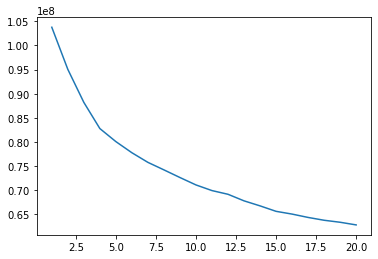

In [65]:
# plot losses
plt.plot(clusters, losses)
plt.show()

## Soft Clustering